# Stellar Mass Functions (SMFs)

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.cosmology import FlatLambdaCDM

import glob
import os
import pickle
    
plt.rc('text', usetex=True)

In [2]:
#change order of default colors for Illustris and TNG
#colors= plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib as mpl
from cycler import cycler
colors=[u'#ff7f0e', u'#2ca02c', u'#9467bd', u'#d62728', u'#1f77b4', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

In [3]:
illustris_color = colors[3]
tng_color = colors[4]

## Modified (from Song) SMF functions

In [4]:
def compute_smf(log_masses, volume, n_bins, min_mass=None, max_mass=None):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
    """
    if not min_mass:
        min_mass = min(log_masses)
    if not max_mass:
        max_mass = max(log_masses)
        
    Phi,edg = np.histogram(log_masses,bins=n_bins, range=[min_mass, max_mass]) #Unnormalized histogram and bin edges
    # Poisson error
    err = np.sqrt(Phi)
    
    #Bin size
    dM    = edg[1] - edg[0]                 
    m_centers   = edg[0:-1] + dM/2.           
    
    #Normalize to volume and bin size
    Phi   = Phi / float(volume) / dM        
    log_phi= np.log10(Phi) 

    # Also normalize the error
    err = err / float(volume) / dM 
    
    return m_centers, Phi, err


def bootstrap_smf(log_masses, volume, n_bins, min_mass, max_mass,
                  n_boots=1000, sm_err=None, resample_err=False):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
        
    log_boot_err : ndarray
        log of Poisson error


    """

    m_centers, phi, err_poisson = compute_smf(log_masses, volume, n_bins, min_mass, max_mass)

    if resample_err:
        msg = "Need to provide the error of stellar mass!"
        assert sm_err is not None, msg
        sm_boots = np.asarray(map(lambda mass, err: np.random.normal(mass, err, n_boots),
                log_masses, sm_err))
    else:
        mass_boot_samples = bootstrap_resample(log_masses, n_boots=n_boots)

    phi_boots = np.vstack(compute_smf(mass_boot_samples[:, ii], volume, n_bins, sm_min, sm_max)[1] 
                              for ii in range(n_boots))
    
    #bootstrap error
    err_bootstrap=np.nanstd(phi_boots, axis=0)
    log_err_bootstrap=np.nanstd(np.log10(phi_boots[phi_boots != 0.0]), axis=0)
    
    
    
    return m_centers, phi, err_poisson, err_bootstrap, log_err_bootstrap, phi_boots

In [5]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

## Read masses

In [6]:
#data
# Illustris_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_orig_11.2.hdf5'
# TNG_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_tng75_11.2.hdf5'
tng_masses_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
illustris_masses_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
BAHAMAS_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/BAHAMAS/bahamas_z0.38_aperture_masses.fits'
Massive_Black_II_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/MassiveBlack-II/mblack2_z0.30_aperture_masses.fits'
Horizon_AGN_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Horizon-AGN/horizon_z0.37_aperture_masses.fits'

HSC_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_wide_massive_fastlane_imgsub_master_use_camira.fits'

In [7]:
tng_masses = open_pkl(tng_masses_file)
illustris_masses = open_pkl(illustris_masses_file)

volume_illustris=106.5**3 #Mpc^3
z_illustris = 0.4

In [8]:
tng_masses[0]

m_1d_10,m_1d_30,m_1d_100,m_1d_500,m_1d_800,m_2d_10,m_2d_30,m_2d_100,m_2d_500,m_2d_800,extrapolated_m_300,extrapolated_m_500,extrapolated_m_800,m_cat,m_post,m_post_icl,m_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11.76024172759147,12.093535699995554,12.289991662656853,12.380527665748408,12.380527665748408,11.77350757938413,12.101761879109436,12.303738186458856,12.377627652942456,12.377627652942456,12.409390191068832,12.445570328574874,12.472189976011201,12.449948294587058,12.377627652227904,12.377636378979057,14.258397495616956


## SMFs 

#### Illustris & TNG 

In [9]:
n_bins = 5

m10_illustris, smf10_illustris, err10_illustris = compute_smf(illustris_masses['m_1d_10'], volume_illustris, n_bins=6, 
                                                              min_mass=11.2)
m10_tng, smf10_tng, err10_tng = compute_smf(tng_masses['m_1d_10'], volume_illustris,n_bins=3, min_mass=11.2)

m30_illustris, smf30_illustris, err30_illustris = compute_smf(illustris_masses['m_1d_30'], volume_illustris,n_bins,
                                                              min_mass=11.2)
m30_tng, smf30_tng, err30_tng = compute_smf(tng_masses['m_1d_30'], volume_illustris,n_bins, min_mass=11.2)

m100_illustris, smf100_illustris, err100_illustris = compute_smf(illustris_masses['m_1d_100'], volume_illustris,n_bins,
                                                              min_mass=11.2)
m100_tng, smf100_tng, err100_tng = compute_smf(tng_masses['m_1d_100'], volume_illustris,n_bins, min_mass=11.2)

#outer masses

m_outer_illustris, smf_outer_illustris, err_outer_illustris = compute_smf(np.log10(10**illustris_masses['m_1d_100'] - 10**illustris_masses['m_1d_30']), 
                                                                          volume_illustris,n_bins,
                                                                          min_mass=10.5)
m_outer_tng, smf_outer_tng, err_outer_tng = compute_smf(np.log10(10**tng_masses['m_1d_100'] - 10**tng_masses['m_1d_30']),
                                                        volume_illustris,n_bins,
                                                        min_mass=10.5)


9.738840633002976
10.170872772711213
7.090503741631743


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


<function matplotlib.pyplot.show>

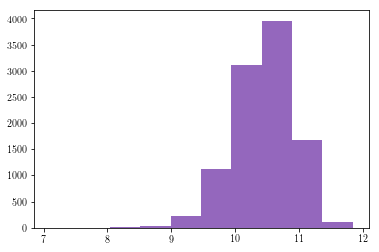

In [12]:
plt.hist(np.log10(10**illustris_masses['m_1d_100'] - 10**illustris_masses['m_1d_30']))
print(min(np.log10(10**illustris_masses['m_1d_100'] - 10**illustris_masses['m_1d_30'])))
plt.show

plt.hist(np.log10(10**tng_masses['m_1d_100'] - 10**tng_masses['m_1d_30']))
print(min(np.log10(10**tng_masses['m_1d_100'] - 10**tng_masses['m_1d_30'])))
plt.show

plt.hist(np.log10(10**fastMaster['logm_100'] - 10**fastMaster['logm_30']))
print(min(np.log10(10**fastMaster['logm_100'] - 10**fastMaster['logm_30'])))
plt.show

#### HSC 

In [13]:
#HSC
fastMaster = Table.read(HSC_file, format='fits')

print max(fastMaster['MSTAR'])
print min(fastMaster['MSTAR'])
print len(fastMaster['MSTAR'])

12.263241
10.752697
10293


In [14]:
# h0 
HSMALL = 0.70
H0 = 70.0
# S16A 
S16A_AREA = 144.7  # deg^2

In [15]:
# Stellar mass function
cosmo = FlatLambdaCDM(H0=H0, Om0=0.300)
s16a_vol = ((cosmo.comoving_volume(0.52) - cosmo.comoving_volume(0.19)) * 
            (S16A_AREA / 41253.0)).value
print("# Volume for HSC : %f Mpc^3" % s16a_vol)
m_hsc, smf_hsc, err_hsc = compute_smf(fastMaster['MSTAR'], s16a_vol, n_bins=15, min_mass=11.2)

m100_hsc, smf100_hsc, err100_hsc = compute_smf(fastMaster['logm_100'], s16a_vol, n_bins=15, min_mass=11.5)
m30_hsc, smf30_hsc, err30_hsc = compute_smf(fastMaster['logm_30'], s16a_vol, n_bins=15, min_mass=11.4)
m10_hsc, smf10_hsc, err10_hsc = compute_smf(fastMaster['logm_10'], s16a_vol, n_bins=15, min_mass=11.2)

m_outer_hsc, smf_outer_hsc, err_outer_hsc = compute_smf(np.log10(10**fastMaster['logm_100'] - 10**fastMaster['logm_30']),
                                            s16a_vol, n_bins=15, min_mass=10.5)

s16aMLow1 = np.nanpercentile(smf_hsc, 3.0, axis=0)
s16aMUpp1 = np.nanpercentile(smf_hsc, 97.0, axis=0)
s16aMMed1 = np.nanmedian(smf_hsc, axis=0)

# Volume for HSC : 102650636.444615 Mpc^3


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


In [21]:
def make_SMF_plot(hsc_m_bins, hsc_phi, hsc_err,
                  illustris_m_bins, illustris_phi, illustris_err,
                  tng_m_bins, tng_phi, tng_err,
                  mass_radius):
    
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)

    #HSC
    ax1.plot(hsc_m_bins, np.log10(hsc_phi), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
    ax1.fill_between(hsc_m_bins, np.log10(hsc_phi-hsc_err), np.log10(hsc_phi+hsc_err), alpha=0.3, rasterized=True,
                     color='k')

    #Illustris
    ax1.plot(illustris_m_bins,np.log10(illustris_phi), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
             color=illustris_color, label=r'$\mathrm{Illustris}$')
    ax1.fill_between(illustris_m_bins, np.log10(illustris_phi-illustris_err), np.log10(illustris_phi+illustris_err),
                     color=illustris_color,  alpha=0.3, rasterized=True)

    #TNG
    ax1.plot(tng_m_bins,np.log10(tng_phi), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
             color=tng_color, label=r'$\mathrm{TNG}100$')
    ax1.fill_between(tng_m_bins, np.log10(tng_phi-tng_err), np.log10(tng_phi+tng_err),
                     color=tng_color, alpha=0.3, rasterized=True)

    # Legend
    ax1.legend(loc='upper right', fontsize=30, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

    # X-Y limits
    if mass_radius == 'outer':
        ax1.set_xlim(10.5, 11.8)
        ax1.set_ylim(-6, -3)
        plt.xlabel(r'$\log (M_{{\star,  100  \mathrm{{kpc}}}} - M_{{\star,  30  \mathrm{{kpc}}}}/M_{{\odot}})$',
                   fontsize=40)
#         ax1.text(0.03, 0.2,r'$M_{{\star,  100  \mathrm{{kpc}}}} - M_{{\star,  30  \mathrm{{kpc}}}}$',
#                  size=60, zorder=15, transform=ax1.transAxes)
        ax1.text(0.65, 0.6, r'$M_{{\star,  \mathrm{outer}}}$', size=60, zorder=15,
            transform=ax1.transAxes)
    else:
        ax1.set_xlim(11.2, 12.3)
        ax1.set_ylim(-5.1, -3)
        ax1.set_xlabel(r'$\log\ (M_{{\star, {0} \mathrm{{kpc}}}}/M_{{\odot}})$'.format(mass_radius), 
                   size=40)
        ax1.text(0.6, 0.6, r'$M_{{\star,  {0}  \mathrm{{kpc}}}}$'.format(str(mass_radius)), size=60, zorder=15,
            transform=ax1.transAxes)

    # Label
    
    ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
                   size=40)
    ax1.tick_params(axis='both', which='major', labelsize=30)
    

    
    
    if mass_radius == 100:
        ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

    #prevent top from disappearing
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)

    fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF{0}_Illustris+TNG+HSC.pdf'.format(mass_radius), dpi=100, format='pdf')

    #plt.title(r'$M_{\star\_100}$',size=60)
    plt.show()

## M10

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


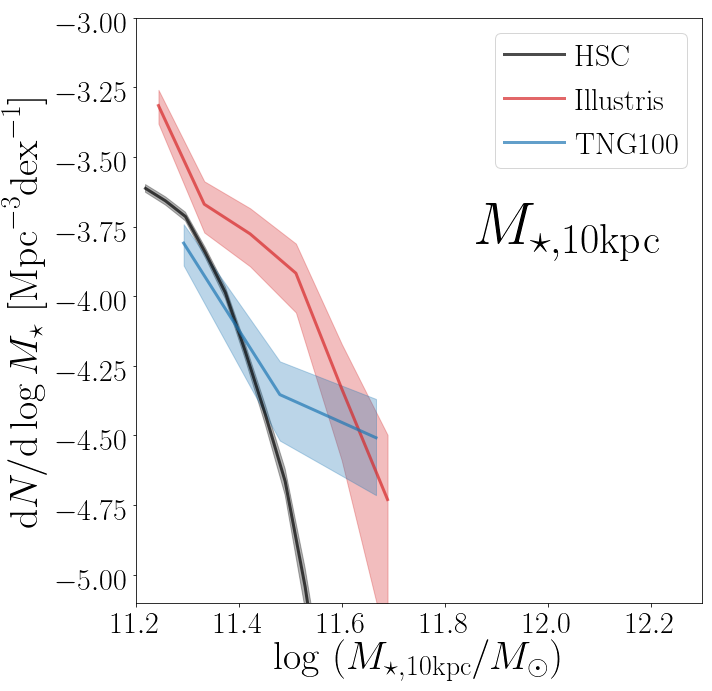

In [22]:
make_SMF_plot(m10_hsc, smf10_hsc, err10_hsc,
                  m10_illustris, smf10_illustris, err10_illustris,
                  m10_tng, smf10_tng, err10_tng,
                  10)

## M_30

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


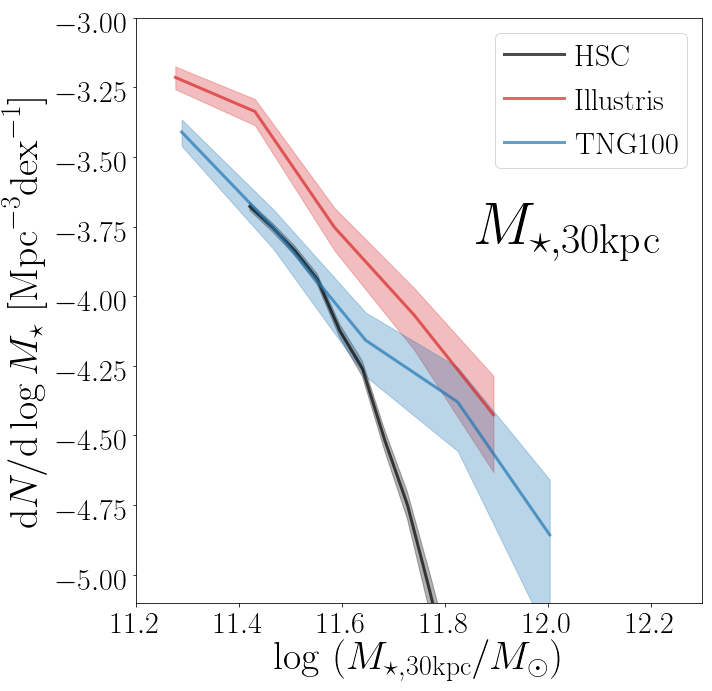

In [23]:
make_SMF_plot(m30_hsc, smf30_hsc, err30_hsc,
                  m30_illustris, smf30_illustris, err30_illustris,
                  m30_tng, smf30_tng, err30_tng,
                  30)

## M_100

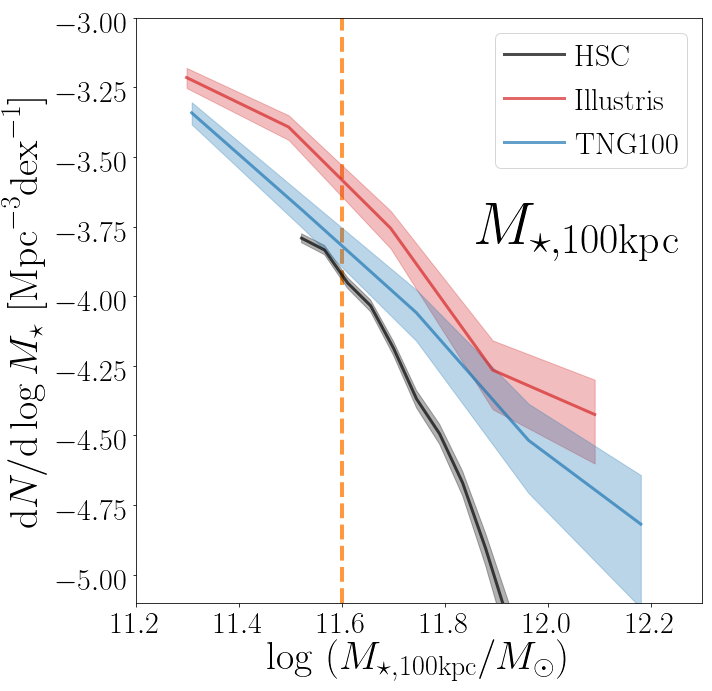

In [24]:
make_SMF_plot(m100_hsc, smf100_hsc, err100_hsc,
                  m100_illustris, smf100_illustris, err100_illustris,
                  m100_tng, smf100_tng, err100_tng,
                  100)

## M_outer 

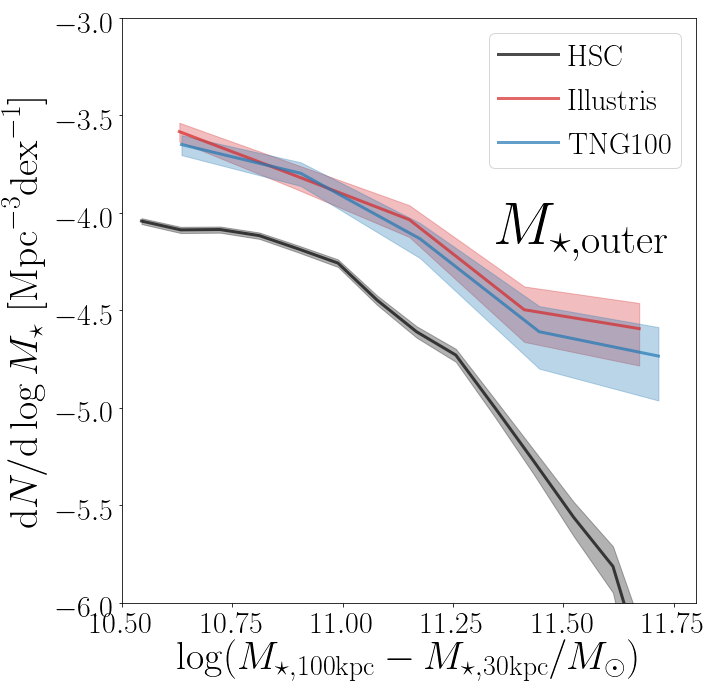

In [25]:
make_SMF_plot(m_outer_hsc, smf_outer_hsc, err_outer_hsc,
                  m_outer_illustris, smf_outer_illustris, err_outer_illustris,
                  m_outer_tng, smf_outer_tng, err_outer_tng,
                  'outer')